# Music Generation with Melody CNN and Conditional CNN

## Imports

In [ ]:
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -qU pyfluidsynth pretty_midi
!pip install music21
!pip install pypianoroll

W: GPG error: https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease: The following signatures couldn't be verified because the public key is not available: NO_PUBKEY A4B469963BF863CC
E: The repository 'https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease' is no longer signed.
     |████████████████████████████████| 5.6 MB 5.8 MB/s 
     |████████████████████████████████| 51 kB 5.0 MB/s 


In [ ]:
import os
import shutil
import glob
import numpy as np 
import pandas as pd
import pretty_midi
import pypianoroll
import tables
from music21 import converter, instrument, note, chord, stream
import music21
import librosa
import librosa.display
import matplotlib.pyplot as plt
from keras.utils import np_utils
import json
import IPython.display
from datetime import datetime
import random
import itertools

import torch
import torch.nn as nn
from torch.nn import functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data extraction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Open data into content folder
!tar -xf "/content/drive/MyDrive/music_generation/lmd_matched_h5.tar.gz" -C "/content/"
!tar -xf "/content/drive/MyDrive/music_generation/lmd_matched.tar.gz" -C "/content/"
!tar -xf "/content/drive/MyDrive/music_generation/lpd_5_cleansed.tar.gz" -C "/content/"

In [ ]:
# Open the cleansed ids file
cleansed_ids = pd.read_csv(os.path.join('/content/drive/MyDrive/music_generation', 'cleansed_ids.txt'), delimiter = '    ', header = None)
lpd_to_msd_ids = {a:b for a, b in zip(cleansed_ids[0], cleansed_ids[1])}
msd_to_lpd_ids = {a:b for a, b in zip(cleansed_ids[1], cleansed_ids[0])}

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [ ]:
# Reading the genre annotations
genre_file_dir = os.path.join('/content/drive/MyDrive/music_generation', 'msd_tagtraum_cd1.cls')
ids = []
genres = []
with open(genre_file_dir) as f:
    line = f.readline()
    while line:
        if line[0] != '#':
          split = line.strip().split("\t")
          if len(split) == 2:
            ids.append(split[0])
            genres.append(split[1])
          elif len(split) == 3:
            ids.append(split[0])
            ids.append(split[0])
            genres.append(split[1])
            genres.append(split[2])
        line = f.readline()
genre_df = pd.DataFrame(data={"TrackID": ids, "Genre": genres})

genre_dict = genre_df.groupby('TrackID')['Genre'].apply(lambda x: x.tolist()).to_dict()
genre_dict

{'TRAAAAK128F9318786': ['Pop_Rock'],
 'TRAAAAW128F429D538': ['Rap'],
 'TRAAABD128F429CF47': ['Pop_Rock'],
 'TRAAAED128E0783FAB': ['Jazz', 'Vocal'],
 'TRAAAEF128F4273421': ['Pop_Rock'],
 'TRAAAEM128F93347B9': ['Electronic'],
 'TRAAAFD128F92F423A': ['Pop_Rock'],
 'TRAAAGR128F425B14B': ['Pop_Rock'],
 'TRAAAHZ128E0799171': ['Rap'],
 'TRAAAIR128F1480971': ['Pop_Rock', 'RnB'],
 'TRAAANK128F428B515': ['Pop_Rock', 'Electronic'],
 'TRAAARJ128F9320760': ['Pop_Rock'],
 'TRAABFH128F92C812E': ['Pop_Rock'],
 'TRAABHO12903D08576': ['Jazz'],
 'TRAABIG128F9356C56': ['Pop_Rock'],
 'TRAABJS128F9325C99': ['Pop_Rock'],
 'TRAABLR128F423B7E3': ['Pop_Rock'],
 'TRAABNV128F425CEE1': ['New Age', 'Jazz'],
 'TRAABOG128F42955B1': ['Pop_Rock'],
 'TRAABWH128F427ABE8': ['Jazz', 'Pop_Rock'],
 'TRAABWX128F1464374': ['Electronic', 'Pop_Rock'],
 'TRAACER128F4290F96': ['Pop_Rock', 'Jazz'],
 'TRAACEU128F92C3B82': ['Jazz'],
 'TRAACJD128E078926C': ['Pop_Rock'],
 'TRAACLG128F4276511': ['Electronic'],
 'TRAACMJ128F930C704': ['P

In [ ]:
genre = 'Pop_Rock'

In [ ]:
# Get all song MSD IDs in some genre
song_msd_ids = [k for k in genre_dict.keys() if genre in genre_dict[k]]
song_msd_ids

['TRAAAAK128F9318786',
 'TRAAABD128F429CF47',
 'TRAAAEF128F4273421',
 'TRAAAFD128F92F423A',
 'TRAAAGR128F425B14B',
 'TRAAAIR128F1480971',
 'TRAAANK128F428B515',
 'TRAAARJ128F9320760',
 'TRAABFH128F92C812E',
 'TRAABIG128F9356C56',
 'TRAABJS128F9325C99',
 'TRAABLR128F423B7E3',
 'TRAABOG128F42955B1',
 'TRAABWH128F427ABE8',
 'TRAABWX128F1464374',
 'TRAACER128F4290F96',
 'TRAACJD128E078926C',
 'TRAACMJ128F930C704',
 'TRAACPH12903CF5F14',
 'TRAACQT128F9331780',
 'TRAADCQ128F932EC14',
 'TRAADKW128E079503A',
 'TRAADQL128F427D281',
 'TRAADQW128F427CE68',
 'TRAADQX128F422B4CF',
 'TRAAEAM128F934B199',
 'TRAAEDA12903CA1EFC',
 'TRAAEEO128F4288E88',
 'TRAAEJV128F423CF04',
 'TRAAEMJ128F425A917',
 'TRAAENM128EF33EDAA',
 'TRAAEPG128F429139A',
 'TRAAEWG128F930B3A4',
 'TRAAFDU128F426E91A',
 'TRAAFEI128F422D353',
 'TRAAFEU128E078581C',
 'TRAAFGQ128F427D884',
 'TRAAFML128F1451AF1',
 'TRAAFMT128F429DB58',
 'TRAAFOH128E078BD7E',
 'TRAAFOY128F146CC17',
 'TRAAFRU128F9339158',
 'TRAAFTE128F429545F',
 'TRAAFYL12

In [ ]:
# Helpers for finding needed files
def msd_id_to_dirs(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)


def msd_id_to_h5(msd_id):
    """Given an MSD ID, return the path to the corresponding h5"""
    return os.path.join('lmd_matched_h5',
                        msd_id_to_dirs(msd_id) + '.h5')

# Load the midi npz file from the LMD cleansed folder
def get_midi_npz_path(msd_id, midi_md5):
    return os.path.join('lpd_5/lpd_5_cleansed',
                        msd_id_to_dirs(msd_id), midi_md5 + '.npz')
    
# Load the midi file from the Music Dataset folder
def get_midi_path(msd_id, midi_md5):
    return os.path.join('lmd_matched', msd_id_to_dirs(msd_id), midi_md5 + '.mid')

## Data preparation

In [ ]:
combined_pianorolls = []
i = 0

for msd_file_name in song_msd_ids:
  if msd_file_name not in msd_to_lpd_ids:
      continue
  lpd_file_name = msd_to_lpd_ids[msd_file_name]
  # Get the NPZ path
  npz_path = get_midi_npz_path(msd_file_name, lpd_file_name)
  multitrack = pypianoroll.load(npz_path)
  multitrack.set_resolution(2).pad_to_same()

  # Piano, Guitar, Bass, Strings, Drums
  # Splitting into different parts

  parts = {'piano_part': None, 'guitar_part': None, 'bass_part': None, 'strings_part': None, 'drums_part': None}
  song_length = None
  empty_array = None
  has_empty_parts = False
  for track in multitrack.tracks:
    if track.name == 'Drums':
      parts['drums_part'] = track.pianoroll
    if track.name == 'Piano':
      parts['piano_part'] = track.pianoroll
    if track.name == 'Guitar':
      parts['guitar_part'] = track.pianoroll
    if track.name == 'Bass':
      parts['bass_part'] = track.pianoroll
    if track.name == 'Strings':
      parts['strings_part'] = track.pianoroll
    if track.pianoroll.shape[0] > 0:
      empty_array = np.zeros_like(track.pianoroll)

  for k,v in parts.items():
    if v.shape[0] == 0:
      parts[k] = empty_array.copy()
      has_empty_parts = True

  # Stack all together - Piano, Guitar, Bass, Strings, Drums
  combined_pianoroll = torch.tensor([parts['piano_part'], parts['guitar_part'], parts['bass_part'], parts['strings_part'], parts['drums_part']])

  # These contain velocity information - the force with which the notes are hit - which can be standardized to 0/1 if we want (to compress)
  if has_empty_parts == False:
    combined_pianorolls.append(combined_pianoroll)
    i+=1
    # print(i)
  if i % 100 == 0:
    print(i)

  if i == 1000:
    break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


100
200
300
400
500
600
700
800
900
1000


In [ ]:
pianoroll_lengths = [e.size()[1] for e in combined_pianorolls]
combined_pianorolls = torch.hstack(combined_pianorolls)

In [ ]:
pianoroll_lengths = torch.tensor(pianoroll_lengths)
pianoroll_lengths = pianoroll_lengths.numpy()
pianoroll_cum_lengths = pianoroll_lengths.cumsum()

In [ ]:
# Normalize
combined_pianorolls = combined_pianorolls / 127.0

# Getting the number of notes played in that time step

# Number of notes per time step per track
notes_per_time_step = (combined_pianorolls > 0).type(torch.float32).sum(axis = 2)

# Censor those with more than 10 notes to be 10
notes_per_time_step[notes_per_time_step > 10] = 10

# Normalize to be between [0, 4] - very important to get right
notes_per_time_step = notes_per_time_step / 2
notes_per_time_step = notes_per_time_step.unsqueeze(2)

# Concatenate the number vector
combined_pianorolls = torch.cat((combined_pianorolls, notes_per_time_step), dim = 2)


# Remake the list of pianorolls - ensuring all songs are multiple of 32
pianorolls_list = []
pianorolls_list.append(combined_pianorolls[:, :(pianoroll_cum_lengths[0] - pianoroll_cum_lengths[0] % 32), :])
for i in range(len(pianoroll_cum_lengths) - 1):
  length = pianoroll_cum_lengths[i+1] - pianoroll_cum_lengths[i]
  # Get the nearest multiple of 32
  length_multiple = length - (length % 32)
  pianoroll = combined_pianorolls[:, pianoroll_cum_lengths[i]:(pianoroll_cum_lengths[i] + length_multiple), :]

  # Remove zero pianorolls
  if pianoroll.sum() != 0 and len(pianoroll) != 0:
      pianorolls_list.append(pianoroll)

# Combine the pianorolls again
combined_pianorolls = torch.hstack(pianorolls_list)

## Forming Datasets

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Dataset which only returns sequences which are multiples of 32
class CombinedDataset(Dataset):
  def __init__(self, pianorolls, instrument_id):
    self.data = pianorolls
    self.length = int(pianorolls.size(1) / 32)
    self.instrument_id = instrument_id

  def __getitem__(self, index):
    sequence = self.data[self.instrument_id, (index * 32):((index+1) * 32), :]
    return sequence
    
  def __len__(self):
    return self.length

In [ ]:
# Generation Dataset - all fields cannot be blank
class GenerationDataset(Dataset):
  def __init__(self, list_of_sequences, dataset_length = 32 * 10000, seq_length = 50):

    # Don't normalize anymore since it was done earlier
    self.data = list_of_sequences
    self.n_songs = len(list_of_sequences)
    self.seq_length = seq_length
    self.length = dataset_length

  def __getitem__(self, index):

    valid_sequence = False
    while valid_sequence == False:
      # Choose a random song id
      song_id = random.randint(0, self.n_songs - 1)
      song_length = self.data[song_id].size()[1]
      # Choose a random start window
      start_time = random.randint(0, song_length - self.seq_length * 2 - 2)
      start_time = start_time - (start_time % 32)
      # Check that every track is not empty
      piano_sequence = self.data[song_id][0, start_time:(start_time + self.seq_length), :]
      guitar_sequence = self.data[song_id][1, start_time:(start_time + self.seq_length), :]
      bass_sequence = self.data[song_id][2, start_time:(start_time + self.seq_length), :]
      strings_sequence = self.data[song_id][3, start_time:(start_time + self.seq_length), :]
      drums_sequence = self.data[song_id][4, start_time:(start_time + self.seq_length), :]

      if piano_sequence.sum() != 0 and guitar_sequence.sum() != 0 and bass_sequence.sum() != 0 \
      and strings_sequence.sum() != 0 and drums_sequence.sum() != 0:
        valid_sequence = True
      else:
        if random.random() < 0.1:
          valid_sequence = True

    train_sequence = self.data[song_id][:, start_time:(start_time + self.seq_length), :]
    target_sequence = self.data[song_id][:, (start_time + self.seq_length):(start_time + self.seq_length * 2), :]
    return train_sequence, target_sequence

  def __len__(self):
    return self.length

In [ ]:
# Melody prediction dataset - predict the next melody given the current melody
class MelodyDataset(Dataset):
  def __init__(self, list_of_sequences, dataset_length = 32 * 10000, seq_length = 50):

    # Don't normalize anymore since it was done earlier
    self.data = list_of_sequences
    self.n_songs = len(list_of_sequences)
    self.seq_length = seq_length
    self.length = dataset_length

  def __getitem__(self, index):
    valid_sequence = False

    while valid_sequence == False:
      # Choose a random song id
      # print(self.n_songs)
      try:
        song_id = random.randint(0, self.n_songs - 1)
      except:
        print("bad")
        continue
      song_length = self.data[song_id].size()[1]

      # Choose a random start window
      start_range = song_length - self.seq_length * 2 - 2
      if start_range <= 0:
          continue
      start_time = random.randint(0, start_range)

      # train_sequence: 1 (piano) x seq_length x 128
      train_sequence = self.data[song_id][0, start_time:(start_time + self.seq_length), :]
      # target_sequence: 1 (piano) x seq_length x 128
      target_sequence = self.data[song_id][0, (start_time + self.seq_length):(start_time + self.seq_length * 2), :]

      if train_sequence.sum() != 0 and target_sequence.sum() != 0:
        valid_sequence = True

    return train_sequence[:, 1:], target_sequence[:, 1:]

  def __len__(self):
    return self.length

In [ ]:
# Melody-conditional dataset NEW - returns BOTH the previous harmony, and current melody, and current harmony
# only outputs samples with all tracks non-empty
class ConditionalDataset(Dataset):
  def __init__(self, list_of_sequences, dataset_length = 32 * 1000, seq_length = 50, instrument = 'guitar'):

    self.data = list_of_sequences
    self.n_songs = len(list_of_sequences)
    self.seq_length = seq_length
    self.length = dataset_length
    self.instrument = instrument

  def __getitem__(self, index):
    valid_sequence = False

    while valid_sequence == False:
      song_id = random.randint(0, self.n_songs - 1)
      song_length = self.data[song_id].size()[1]

      # Choose a random start window
      start_range = song_length - self.seq_length * 2 - 2
      if start_range <= 0:
          continue
      start_time = random.randint(0, start_range)

      # train_sequence: 1 (piano) x seq_length x 128
      piano_sequence = self.data[song_id][0, (start_time + self.seq_length):(start_time + self.seq_length * 2), :]

      if self.instrument == 'guitar':
        past_sequence = self.data[song_id][1, start_time:(start_time + self.seq_length), :]
        target_sequence = self.data[song_id][1, (start_time + self.seq_length):(start_time + self.seq_length * 2), :]
      elif self.instrument == 'bass':
        past_sequence = self.data[song_id][2, start_time:(start_time + self.seq_length), :]
        target_sequence = self.data[song_id][2, (start_time + self.seq_length):(start_time + self.seq_length * 2), :]
      elif self.instrument == 'strings':
        past_sequence = self.data[song_id][3, start_time:(start_time + self.seq_length), :]
        target_sequence = self.data[song_id][3, (start_time + self.seq_length):(start_time + self.seq_length * 2), :]
      elif self.instrument == 'drums':
        past_sequence = self.data[song_id][4, start_time:(start_time + self.seq_length), :]
        target_sequence = self.data[song_id][4, (start_time + self.seq_length):(start_time + self.seq_length * 2), :]
      else:
        past_sequence = None
        target_sequence = None

      if piano_sequence.sum() != 0 and past_sequence.sum() != 0 and target_sequence.sum() != 0:
        valid_sequence = True

    return piano_sequence[:, 1:], past_sequence[:, 1:], target_sequence[:, 1:]
  def __len__(self):
    return self.length

## Models code

In [ ]:
# MelodyCNN - uses previous melody to predict next melody
class MelodyCNN(nn.Module):
    def __init__(self, latent_size = 64):
        super(MelodyCNN, self).__init__()

        # Encoding layers
        self.enc_conv1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = (4, 4), stride = (4, 4))
        self.enc_conv2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (4, 4), stride = (4, 4))
        self.enc_conv3 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (2, 8), stride = (2, 8))
        self.enc_lin = nn.Linear(256, latent_size)

        # Decoding layers
        self.dec_lin = nn.Linear(latent_size, 256)
        self.dec_conv1 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = (2, 8), stride = (2, 8))
        self.dec_conv2 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = (4, 4), stride = (4, 4))
        self.dec_conv3 = nn.ConvTranspose2d(in_channels = 64, out_channels = 1, kernel_size = (4, 4), stride = (4, 4))

        self.dropout = nn.Dropout(0.4)
        self.batch_norm_2d64 = nn.BatchNorm2d(64)
        self.batch_norm_2d128 = nn.BatchNorm2d(128)
        self.batch_norm_2d256 = nn.BatchNorm2d(256)

    def forward(self, input):
        # Input: batch_size x seq_length x n_pitches 
        input = input.unsqueeze(1)
        # batch_size x num_channels (1) x seq_length x n_pitches 
        x = F.relu(self.batch_norm_2d64(self.enc_conv1(input)))
        x = self.dropout(x)
        x = F.relu(self.batch_norm_2d128(self.enc_conv2(x)))
        x = self.dropout(x)
        x = F.relu(self.batch_norm_2d256(self.enc_conv3(x)))

        x = x.squeeze(3).squeeze(2)
        latent = self.enc_lin(x)
        x = F.relu(self.dec_lin(latent))
        x = x.unsqueeze(2).unsqueeze(3)
        x = F.relu(self.batch_norm_2d128(self.dec_conv1(x)))
        x = F.relu(self.batch_norm_2d64(self.dec_conv2(x)))
        x = F.relu(self.dec_conv3(x))
        x = x.squeeze()
        return x, latent

In [ ]:
# ConditionalCNN - uses current melody and previous harmony to predict next harmony
class ConditionalCNN(nn.Module):
    def __init__(self, latent_size = 64):
        super(ConditionalCNN, self).__init__()

        # Encoding layers
        self.enc_conv1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = (4, 4), stride = (4, 4))
        self.enc_conv2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (4, 4), stride = (4, 4))
        self.enc_conv3 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (2, 8), stride = (2, 8))
        self.enc_lin1 = nn.Linear(512, 256)
        self.enc_lin2 = nn.Linear(256, latent_size)

        # Decoding layers
        self.dec_lin = nn.Linear(latent_size, 256)
        self.dec_conv1 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = (2, 8), stride = (2, 8))
        self.dec_conv2 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = (4, 4), stride = (4, 4))
        self.dec_conv3 = nn.ConvTranspose2d(in_channels = 64, out_channels = 1, kernel_size = (4, 4), stride = (4, 4))

        self.batch_norm_2d64 = nn.BatchNorm2d(64)
        self.batch_norm_2d128 = nn.BatchNorm2d(128)
        self.batch_norm_2d256 = nn.BatchNorm2d(256)

        self.dropout = nn.Dropout(0.4)


    # Melody CNN
    # prev_m -> future_m
    
    # Conditional CNN
    # prev_c + future_m -> future_c
    
    def forward(self, prev_harmony, melody):
        # Input: batch_size x seq_length x n_pitches 
        prev_harmony = prev_harmony.unsqueeze(1)
        # batch_size x num_channels (1) x seq_length x n_pitches 
        prev_harmony = F.relu(self.batch_norm_2d64(self.enc_conv1(prev_harmony)))
        prev_harmony = self.dropout(prev_harmony)
        prev_harmony = F.relu(self.batch_norm_2d128(self.enc_conv2(prev_harmony)))
        prev_harmony = self.dropout(prev_harmony)
        prev_harmony = F.relu(self.batch_norm_2d256(self.enc_conv3(prev_harmony)))
        prev_harmony = prev_harmony.squeeze(3).squeeze(2)

        melody = melody.unsqueeze(1)
        # batch_size x num_channels (1) x seq_length x n_pitches 
        melody = F.relu(self.batch_norm_2d64(self.enc_conv1(melody)))
        melody = self.dropout(melody)
        melody = F.relu(self.batch_norm_2d128(self.enc_conv2(melody)))
        melody = self.dropout(melody)
        melody = F.relu(self.batch_norm_2d256(self.enc_conv3(melody)))
        melody = melody.squeeze(3).squeeze(2)
        
        # Concat melody and previous harmony together
        x = torch.cat((prev_harmony, melody), dim = 1)
        x = F.relu(self.enc_lin1(x))
        latent = self.enc_lin2(x)
        x = F.relu(self.dec_lin(latent))
        x = x.unsqueeze(2).unsqueeze(3)
        x = F.relu(self.batch_norm_2d128(self.dec_conv1(x)))
        x = F.relu(self.batch_norm_2d64(self.dec_conv2(x)))
        x = F.relu(self.dec_conv3(x))
        x = x.squeeze()
        return x, latent

## Preparation for training

In [ ]:
def grad_clipping(net, theta):  
    """Clip the gradient."""
    params = [p for p in net.parameters() if p.requires_grad]

    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [ ]:
def run_epoch(dataloader, model, optimizer, criterion, is_train = True, model_type = 'melody_cnn'):
  
    running_loss = 0
    n_obs = 0
    data_len = 500

    if model_type == 'melody_cnn':
      counter = 0
      
      for train_seq, target_seq in dataloader:
        if counter == data_len:
            break
        counter += 1

        train_seq = train_seq.to(device)
        target_seq = target_seq.to(device)

        output, latent = model(train_seq)
        loss = criterion(output, target_seq)
        if is_train == True:
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
        running_loss += loss.item()
        n_obs += train_seq.size()[0]

    if model_type == 'cond_cnn':
      counter = 0

      for piano_seq, past_seq, target_seq in dataloader:
        if counter == data_len:
            break
        counter += 1
        
        piano_seq = piano_seq.to(device)
        past_seq = past_seq.to(device)
        target_seq = target_seq.to(device)
        
        output, latent = model(past_seq, piano_seq)
        loss = criterion(output, target_seq)
        if is_train == True:
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
        running_loss += loss.item()
        n_obs += piano_seq.size()[0]

    # Return average loss for the input sequence
    return running_loss / n_obs * 100

In [ ]:
def training_loop(model, optimizer, scheduler, criterion, train_dataloader, test_dataloader, model_type = 'melody_cnn', n_epochs = 50):

  train_losses = []
  test_losses = []

  for epoch in range(1, n_epochs + 1):
    model.train()
    print(scheduler.get_last_lr())
    train_epoch_loss = run_epoch(train_dataloader, model, optimizer, criterion, is_train = True, model_type = model_type)
    train_losses.append(train_epoch_loss)
    scheduler.step()

    model.eval()
    test_epoch_loss = run_epoch(test_dataloader, model, optimizer, criterion, is_train = False, model_type = model_type)
    test_losses.append(test_epoch_loss)

    print('Epoch {}, Train Loss: {}, Test Loss: {}, Time: {}'.format(epoch, train_epoch_loss, test_epoch_loss, datetime.now()))

  return train_losses, test_losses

## Training

### Train Melody CNN

[0.0005]
Epoch 1, Train Loss: 0.08655048545915633, Test Loss: 0.12477964131394402, Time: 2022-04-28 19:59:05.755443
[0.00049]
Epoch 2, Train Loss: 0.07235198325943201, Test Loss: 0.13157806127564983, Time: 2022-04-28 20:00:21.270753
[0.00048019999999999996]
Epoch 3, Train Loss: 0.06976707879221067, Test Loss: 0.12995341029018165, Time: 2022-04-28 20:01:33.647706
[0.000470596]
Epoch 4, Train Loss: 0.06814066881779582, Test Loss: 0.13156413811957465, Time: 2022-04-28 20:03:08.163513
[0.00046118407999999996]
Epoch 5, Train Loss: 0.06722487246734091, Test Loss: 0.13764893035404385, Time: 2022-04-28 20:04:25.914756
[0.00045196039839999995]
Epoch 6, Train Loss: 0.060504368384135886, Test Loss: 0.13694458305835724, Time: 2022-04-28 20:05:43.120330
[0.00044292119043199996]
Epoch 7, Train Loss: 0.04834890282945708, Test Loss: 0.13701811626087873, Time: 2022-04-28 20:06:55.920330
[0.00043406276662336]
Epoch 8, Train Loss: 0.04733878799015656, Test Loss: 0.13444952572463081, Time: 2022-04-28 20:0

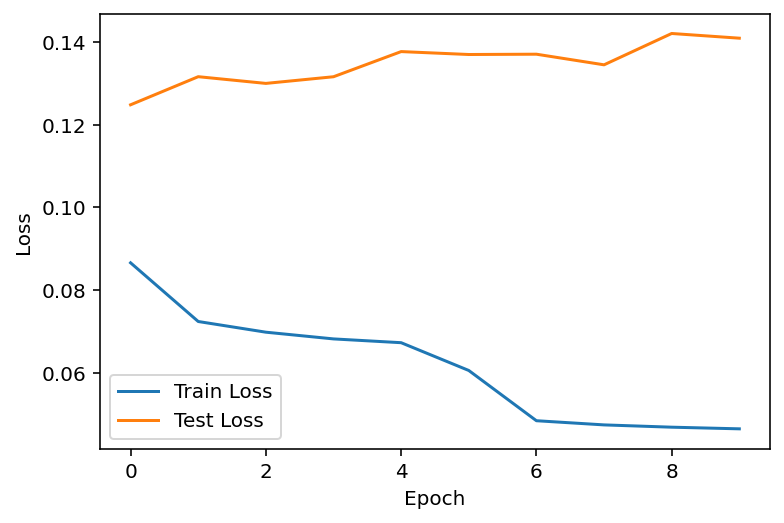

In [ ]:
melody_train_dataset = MelodyDataset(pianorolls_list, dataset_length = 32 * 8000, seq_length = 32)
melody_train_loader = DataLoader(melody_train_dataset, batch_size = 32, drop_last=True)
melody_test_dataset = MelodyDataset(pianorolls_list[900:1000], dataset_length = 32 * 2000, seq_length = 32)
melody_test_loader = DataLoader(melody_test_dataset, batch_size = 32, drop_last=True)

n_epochs = 10
lr = 0.0005
lr_lambda = 0.98

melody_cnn = MelodyCNN(latent_size = 128).to(device)
optimizer = torch.optim.Adam(melody_cnn.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_lambda ** epoch)
criterion = nn.MSELoss()
train_losses, test_losses = training_loop(melody_cnn, optimizer, scheduler, criterion, melody_train_loader, melody_test_loader, model_type = 'melody_cnn', n_epochs = n_epochs)

model_name = 'MelodyCNN'
save_path = os.path.join('/content/drive/MyDrive/music_generation/', 'saved_models', model_name)
torch.save(melody_cnn.state_dict(), save_path)

plt.figure()
plt.plot(train_losses, label = 'Train Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Train Conditional CNN for each instrument

guitar
[0.0005]
Epoch 1, Train Loss: 0.07985033207805828, Test Loss: 0.15013941910583525, Time: 2022-04-28 20:12:20.234280
[0.000495]
Epoch 2, Train Loss: 0.06940392702817917, Test Loss: 0.152117009437643, Time: 2022-04-28 20:14:02.608426
[0.00049005]
Epoch 3, Train Loss: 0.06654044084716589, Test Loss: 0.1410217379685491, Time: 2022-04-28 20:15:45.499948
[0.00048514950000000005]
Epoch 4, Train Loss: 0.061251181934494525, Test Loss: 0.13673037955304607, Time: 2022-04-28 20:17:28.339876
[0.00048029800499999997]
Epoch 5, Train Loss: 0.05591577503364534, Test Loss: 0.13501277107279747, Time: 2022-04-28 20:19:11.326878
[0.00047549502494999995]
Epoch 6, Train Loss: 0.0542728733853437, Test Loss: 0.13368653843645006, Time: 2022-04-28 20:20:54.457602
[0.0004707400747005]
Epoch 7, Train Loss: 0.05007814068812877, Test Loss: 0.13247297734487803, Time: 2022-04-28 20:22:37.781903
[0.00046603267395349497]
Epoch 8, Train Loss: 0.04634565110900439, Test Loss: 0.1336187718086876, Time: 2022-04-28 20:

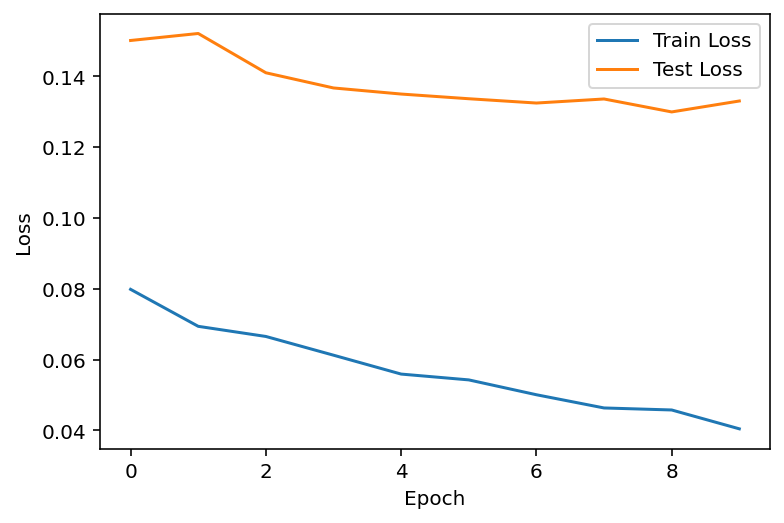

bass
[0.0005]
Epoch 1, Train Loss: 0.044845709335641006, Test Loss: 0.1974154823925346, Time: 2022-04-28 20:29:33.608185
[0.000495]
Epoch 2, Train Loss: 0.025302026586723515, Test Loss: 0.17388933517504482, Time: 2022-04-28 20:31:16.261307
[0.00049005]
Epoch 3, Train Loss: 0.02449117244395893, Test Loss: 0.15559926270507277, Time: 2022-04-28 20:32:58.156774
[0.00048514950000000005]
Epoch 4, Train Loss: 0.024059742930694485, Test Loss: 0.13081736345775424, Time: 2022-04-28 20:34:40.080753
[0.00048029800499999997]
Epoch 5, Train Loss: 0.02354252601508051, Test Loss: 0.11478961512912064, Time: 2022-04-28 20:36:21.312252
[0.00047549502494999995]
Epoch 6, Train Loss: 0.02263090717315208, Test Loss: 0.09970417314907536, Time: 2022-04-28 20:38:02.619924
[0.0004707400747005]
Epoch 7, Train Loss: 0.020491464997758158, Test Loss: 0.09203844943549484, Time: 2022-04-28 20:39:44.005678
[0.00046603267395349497]
Epoch 8, Train Loss: 0.019022168056108058, Test Loss: 0.08082115831784904, Time: 2022-04-

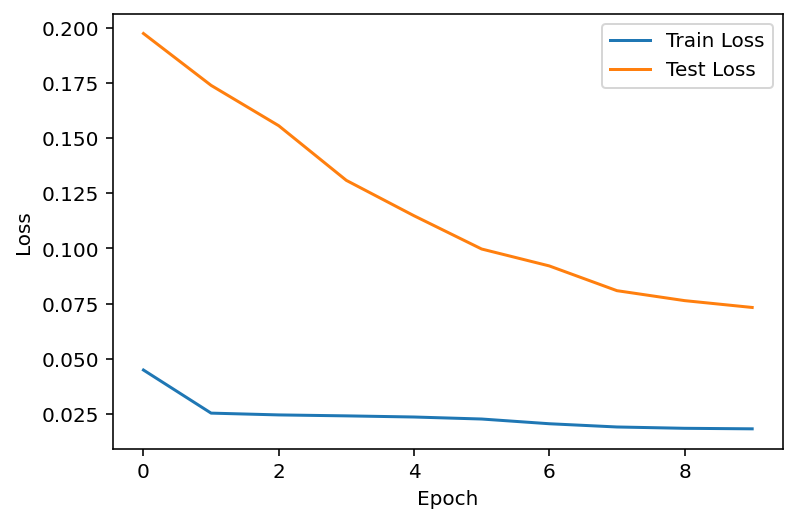

strings
[0.0005]
Epoch 1, Train Loss: 0.0890191548736766, Test Loss: 0.25663572032935916, Time: 2022-04-28 20:46:29.262696
[0.000495]
Epoch 2, Train Loss: 0.07039720066823064, Test Loss: 0.2012354600941762, Time: 2022-04-28 20:48:09.414521
[0.00049005]
Epoch 3, Train Loss: 0.058431730914162476, Test Loss: 0.18790992489084601, Time: 2022-04-28 20:49:50.081760
[0.00048514950000000005]
Epoch 4, Train Loss: 0.057271251583006236, Test Loss: 0.17049203477799893, Time: 2022-04-28 20:51:31.673719
[0.00048029800499999997]
Epoch 5, Train Loss: 0.05580179284443148, Test Loss: 0.1670174704864621, Time: 2022-04-28 20:53:13.401472
[0.00047549502494999995]
Epoch 6, Train Loss: 0.054600837925681836, Test Loss: 0.1590518573531881, Time: 2022-04-28 20:54:55.634676
[0.0004707400747005]
Epoch 7, Train Loss: 0.05452556038508192, Test Loss: 0.16141981887631118, Time: 2022-04-28 20:56:38.584716
[0.00046603267395349497]
Epoch 8, Train Loss: 0.05358661384088918, Test Loss: 0.1466531365411356, Time: 2022-04-28 

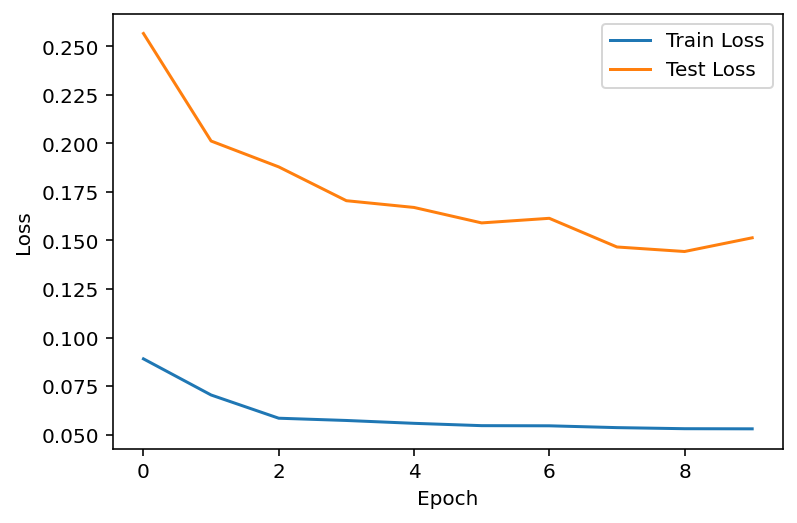

drums
[0.0005]
Epoch 1, Train Loss: 0.045332457646145484, Test Loss: 0.11932757643517107, Time: 2022-04-28 21:03:31.545638
[0.000495]
Epoch 2, Train Loss: 0.030271574162179606, Test Loss: 0.10861868765205145, Time: 2022-04-28 21:05:13.421435
[0.00049005]
Epoch 3, Train Loss: 0.02686178940057289, Test Loss: 0.09676021634368226, Time: 2022-04-28 21:06:53.852665
[0.00048514950000000005]
Epoch 4, Train Loss: 0.022694008966209368, Test Loss: 0.08992585053201764, Time: 2022-04-28 21:08:33.878615
[0.00048029800499999997]
Epoch 5, Train Loss: 0.020810069190338253, Test Loss: 0.08784210835583507, Time: 2022-04-28 21:10:13.202734
[0.00047549502494999995]
Epoch 6, Train Loss: 0.018441148253623398, Test Loss: 0.08193006243091076, Time: 2022-04-28 21:11:52.707412
[0.0004707400747005]
Epoch 7, Train Loss: 0.017887020052876325, Test Loss: 0.07717137205181644, Time: 2022-04-28 21:13:31.615150
[0.00046603267395349497]
Epoch 8, Train Loss: 0.017196921071445104, Test Loss: 0.07247023998061196, Time: 2022

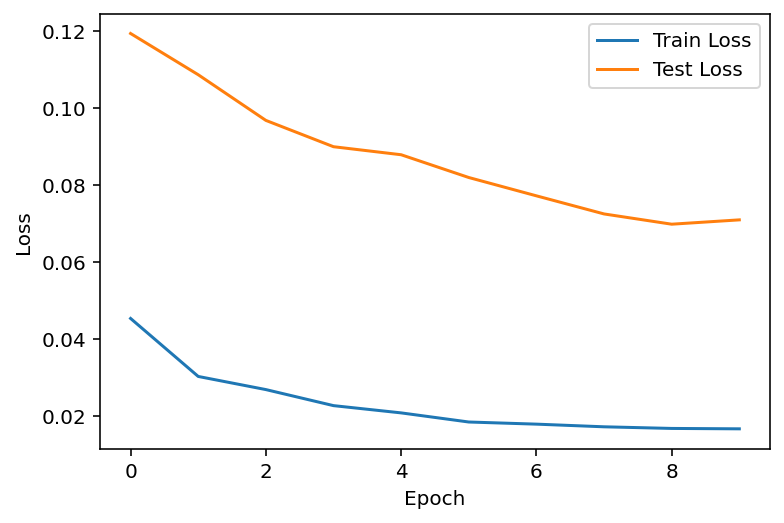

In [ ]:
for instrument in ['guitar', 'bass', 'strings', 'drums']:
  print(instrument)
  cond_train_dataset = ConditionalDataset(pianorolls_list[200:1100], dataset_length = 32 * 4000, seq_length = 32, instrument = instrument)
  cond_train_loader = DataLoader(cond_train_dataset, batch_size = 32, drop_last=True)
  cond_test_dataset = ConditionalDataset(pianorolls_list[0:200], dataset_length = 32 * 1000, seq_length = 32, instrument = instrument)
  cond_test_loader = DataLoader(cond_test_dataset, batch_size = 32, drop_last=True)

  n_epochs = 10
  lr = 0.0005
  lr_lambda = 0.99

  cond_cnn = ConditionalCNN(latent_size = 64).to(device)
  optimizer = torch.optim.Adam(cond_cnn.parameters(), lr = lr)
  scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_lambda ** epoch)
  criterion = nn.MSELoss()
  train_losses, test_losses = training_loop(cond_cnn, optimizer, scheduler, criterion, cond_train_loader, cond_test_loader, model_type = 'cond_cnn', n_epochs = n_epochs)

  model_name = 'CondCNN_{}'.format(instrument)
  save_path = os.path.join('/content/drive/MyDrive/music_generation/', 'saved_models', model_name)
  torch.save(cond_cnn.state_dict(), save_path)

  # Plot the losses over epochs
  plt.figure()
  plt.plot(train_losses, label = 'Train Loss')
  plt.plot(test_losses, label = 'Test Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

## Evaluation by generating new music

In [ ]:
model_name = 'MelodyCNN'
save_path = os.path.join('/content/drive/MyDrive/music_generation/', 'saved_models', model_name)
melody_model = MelodyCNN(latent_size = 128).to(device)
melody_model.load_state_dict(torch.load(save_path))
melody_model.eval()

model_name = 'CondCNN_guitar'
save_path = os.path.join('/content/drive/MyDrive/music_generation/', 'saved_models', model_name)
guitar_model = ConditionalCNN(latent_size = 64).to(device)
guitar_model.load_state_dict(torch.load(save_path))
guitar_model.eval()

model_name = 'CondCNN_bass'
save_path = os.path.join('/content/drive/MyDrive/music_generation/', 'saved_models', model_name)
bass_model = ConditionalCNN(latent_size = 64).to(device)
bass_model.load_state_dict(torch.load(save_path))
bass_model.eval()

model_name = 'CondCNN_strings'
save_path = os.path.join('/content/drive/MyDrive/music_generation/', 'saved_models', model_name)
strings_model = ConditionalCNN(latent_size = 64).to(device)
strings_model.load_state_dict(torch.load(save_path))
strings_model.eval()

model_name = 'CondCNN_drums'
save_path = os.path.join('/content/drive/MyDrive/music_generation/', 'saved_models', model_name)
drums_model = ConditionalCNN(latent_size = 64).to(device)
drums_model.load_state_dict(torch.load(save_path))
drums_model.eval()

In [ ]:
# Generator dataloader and dataset for the actual song generation (gives the full 5 tracks in chunks of length 32)
gen_dataset = GenerationDataset(pianorolls_list[0:900], dataset_length = 32 * 10000, seq_length = 32)
gen_loader = DataLoader(gen_dataset, batch_size = 1, drop_last=True)

In [ ]:
train, test = next(iter(gen_loader))

In [ ]:
# Function that takes in previous length-32 5-instrument sequence, and generates a new length-32 5-instrument sequence
# Input_sequence: 5 x 32 x 128, models: 5-tuple of the trained NNs
# threshold as a % of the maximum output that we will keep the notes there (those under threshold will be moved to 0)
# if binarize = True, will set all remaining non-zero to max intensity
def generate_new_music(input_sequence, models, threshold = 0.3, binarize = False):

  melody_model, guitar_model, bass_model, strings_model, drums_model = models
  input_sequence = input_sequence.to(device)

  melody_prev = input_sequence[0, :, :].unsqueeze(0)
  guitar_prev = input_sequence[1, :, :].unsqueeze(0)
  bass_prev = input_sequence[2, :, :].unsqueeze(0)
  strings_prev = input_sequence[3, :, :].unsqueeze(0)
  drums_prev = input_sequence[4, :, :].unsqueeze(0)

  melody_pred, _ = melody_model(melody_prev)
  melody_pred = melody_pred / melody_pred.max()
  melody_pred[melody_pred < threshold] = 0.0
  

  guitar_pred, _ = guitar_model(guitar_prev, melody_pred.unsqueeze(0))
  guitar_pred = guitar_pred / guitar_pred.max()
  guitar_pred[guitar_pred < threshold] = 0.0

  bass_pred, _ = bass_model(bass_prev, melody_pred.unsqueeze(0))
  bass_pred = bass_pred / bass_pred.max()
  bass_pred[bass_pred < threshold] = 0.0

  strings_pred, _ = strings_model(strings_prev, melody_pred.unsqueeze(0))
  strings_pred = strings_pred / strings_pred.max()
  strings_pred[strings_pred < threshold] = 0.0

  drums_pred, _ = drums_model(drums_prev, melody_pred.unsqueeze(0))
  drums_pred = drums_pred / drums_pred.max()
  drums_pred[drums_pred < threshold] = 0.0
  creation = torch.cat((melody_pred.unsqueeze(0), guitar_pred.unsqueeze(0), bass_pred.unsqueeze(0), 
                        strings_pred.unsqueeze(0), drums_pred.unsqueeze(0)), dim = 0)

  if binarize == True:
    creation[creation > 0] = 1
  return creation

In [ ]:
models = (melody_model, guitar_model, bass_model, strings_model, drums_model)
generated_track = torch.zeros((5, 128, 128))
generated_track[:, 0:32, :] = train.squeeze()[:, :, :128]
creation = generate_new_music(train.squeeze()[:, :, :128], models, threshold = 0.4, binarize = False)
generated_track[:, 32:64, :] = creation
creation = generate_new_music(creation, models, threshold = 0.4, binarize = False)
generated_track[:, 64:96, :] = creation
creation = generate_new_music(creation, models, threshold = 0.4, binarize = False)
generated_track[:, 96:128, :] = creation

In [ ]:
# Only un-normalize here
generated_track_out = generated_track * 127
# Convert predictions into the multitrack pianoroll
piano_track = pypianoroll.StandardTrack(name = 'Piano', program = 0, is_drum = False, pianoroll = generated_track_out[0, :, :].detach().cpu().numpy())
guitar_track = pypianoroll.StandardTrack(name = 'Guitar', program = 24, is_drum = False, pianoroll = generated_track_out[1, :, :].detach().cpu().numpy())
bass_track = pypianoroll.StandardTrack(name = 'Bass', program = 32, is_drum = False, pianoroll = generated_track_out[2, :, :].cpu().detach().numpy())
strings_track = pypianoroll.StandardTrack(name = 'Strings', program = 48, is_drum = False, pianoroll = generated_track_out[3, :, :].cpu().detach().numpy())
drums_track = pypianoroll.StandardTrack(name = 'Drums', is_drum = True, pianoroll = generated_track_out[4, :, :].cpu().detach().numpy())
generated_multitrack = pypianoroll.Multitrack(name = 'Generated', resolution = 2, tracks = [piano_track, guitar_track, bass_track, strings_track, drums_track])
generated_multitrack.plot()

In [ ]:
generated_pm = pypianoroll.to_pretty_midi(generated_multitrack)
generated_midi_audio = generated_pm.fluidsynth()
IPython.display.Audio(generated_midi_audio, rate = 44100)